# LIBRARIES, DATA, AND PREPROCESSING

## Librairies

In [1]:
import sys
print(sys.executable)
!{sys.executable} -m pip install yfinance
import yfinance as yf
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

plt.style.use("seaborn-v0_8")


c:\Users\Emile\anaconda3\python.exe


## Import Data + CSV generation

In [2]:
tickers = {
    "DJ30": "^DJI",     # Dow Jones Industrial Average
    "SNP500": "^GSPC",  # S&P 500 Index
    "CAC40": "^FCHI"    # CAC 40 Index
}
start_date = "2000-01-01"
end_date = "2021-01-01"

for name, symbol in tickers.items():
    # Download data
    data = yf.download(symbol, start=start_date, end=end_date)[["Open", "High", "Low", "Close", "Volume"]]
    
    # Rename columns with prefix, e.g. "CAC40_Open", "CAC40_Close", etc.
    data = data.rename(columns={col: f"{name}__{col}" for col in data.columns})
    
    # Save to CSV
    filename = f"{name}_data.csv"
    data.to_csv(filename, index=True)
    print(data.head(), "\n")


C:\Users\Emile\AppData\Local\Temp\ipykernel_4648\4145998076.py:11: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol, start=start_date, end=end_date)[["Open", "High", "Low", "Close", "Volume"]]
[*********************100%***********************]  1 of 1 completed
C:\Users\Emile\AppData\Local\Temp\ipykernel_4648\4145998076.py:11: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol, start=start_date, end=end_date)[["Open", "High", "Low", "Close", "Volume"]]


Price               Open          High           Low         Close     Volume
Ticker              ^DJI          ^DJI          ^DJI          ^DJI       ^DJI
Date                                                                         
2000-01-03  11501.849609  11522.009766  11305.690430  11357.509766  169750000
2000-01-04  11349.750000  11350.059570  10986.450195  10997.929688  178420000
2000-01-05  10989.370117  11215.099609  10938.669922  11122.650391  203190000
2000-01-06  11113.370117  11313.450195  11098.450195  11253.259766  176550000
2000-01-07  11247.059570  11528.139648  11239.919922  11522.559570  184900000 



[*********************100%***********************]  1 of 1 completed
C:\Users\Emile\AppData\Local\Temp\ipykernel_4648\4145998076.py:11: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol, start=start_date, end=end_date)[["Open", "High", "Low", "Close", "Volume"]]


Price              Open         High          Low        Close      Volume
Ticker            ^GSPC        ^GSPC        ^GSPC        ^GSPC       ^GSPC
Date                                                                      
2000-01-03  1469.250000  1478.000000  1438.359985  1455.219971   931800000
2000-01-04  1455.219971  1455.219971  1397.430054  1399.420044  1009000000
2000-01-05  1399.420044  1413.270020  1377.680054  1402.109985  1085500000
2000-01-06  1402.109985  1411.900024  1392.099976  1403.449951  1092300000
2000-01-07  1403.449951  1441.469971  1400.729980  1441.469971  1225200000 



[*********************100%***********************]  1 of 1 completed

Price              Open         High          Low        Close Volume
Ticker            ^FCHI        ^FCHI        ^FCHI        ^FCHI  ^FCHI
Date                                                                 
2000-01-03  6024.379883  6102.120117  5901.770020  5917.370117      0
2000-01-04  5922.229980  5925.069824  5657.200195  5672.020020      0
2000-01-05  5521.830078  5589.500000  5461.589844  5479.700195      0
2000-01-06  5485.930176  5530.259766  5388.850098  5450.109863      0
2000-01-07  5423.879883  5561.689941  5423.879883  5539.609863      0 



## DATA PREPROCESSING

In [3]:
df_sp = pd.read_csv("SNP500_data.csv")

# Deleting useless columns
df_sp = df_sp[~df_sp["Price"].isin(["Ticker", "Date"])].copy()

#The "price" collumn are actuallt dates
df_sp["Date"] = pd.to_datetime(df_sp["Price"])
df_sp = df_sp.drop(columns=["Price"])
df_sp = df_sp.set_index("Date")

#Make sure that every column has numerical values
for col in df_sp.columns:
    df_sp[col] = pd.to_numeric(df_sp[col], errors="coerce")

print(df_sp.head())
print(df_sp.info())

                   Open         High          Low        Close      Volume
Date                                                                      
2000-01-03  1469.250000  1478.000000  1438.359985  1455.219971   931800000
2000-01-04  1455.219971  1455.219971  1397.430054  1399.420044  1009000000
2000-01-05  1399.420044  1413.270020  1377.680054  1402.109985  1085500000
2000-01-06  1402.109985  1411.900024  1392.099976  1403.449951  1092300000
2000-01-07  1403.449951  1441.469971  1400.729980  1441.469971  1225200000
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5284 entries, 2000-01-03 to 2020-12-31
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    5284 non-null   float64
 1   High    5284 non-null   float64
 2   Low     5284 non-null   float64
 3   Close   5284 non-null   float64
 4   Volume  5284 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 247.7 KB
None


In [4]:
#creating a copy on which we will work
data = df_sp.copy()

# returns
data["return_1d"] = data["Close"].pct_change()

# target: next day's return
data["target_return_1d"] = data["return_1d"].shift(-1)

# classification if the return is > 0 or not
data["target_direction"] = (data["target_return_1d"] > 0).astype(int)

# cleaning: remove NaN due to shifts
data = data.dropna()

# final preview
print("\nFinal dataset preview:")
display(data.head())


print("\nFinal shape:", data.shape)


Final dataset preview:


,Open,High,Low,Close,Volume,return_1d,target_return_1d,target_direction
Date,,,,,,,,
2000-01-04,1455.219971,1455.219971,1397.430054,1399.420044,1009000000,-0.038345,0.001922,1
2000-01-05,1399.420044,1413.270020,1377.680054,1402.109985,1085500000,0.001922,0.000956,1
2000-01-06,1402.109985,1411.900024,1392.099976,1403.449951,1092300000,0.000956,0.027090,1
2000-01-07,1403.449951,1441.469971,1400.729980,1441.469971,1225200000,0.027090,0.011190,1
2000-01-10,1441.469971,1464.359985,1441.469971,1457.599976,1064800000,0.011190,-0.013063,0



Final shape: (5282, 8)


## SPLITTING DATA

We will split our data chronologically (time-series split) to avoid look-ahead bias:

- **Train:** 2000–2014  
- **Validation:** 2015–2017  
- **Test:** 2018–2020

This provides a larger training history while keeping evaluation strictly out-of-sample.


In [ ]:
# Time-series split (by date)
# IMPORTANT:
# - No shuffling.
# - All preprocessing that requires fitting (e.g., StandardScaler) must be fit on TRAIN only.

# Define split boundaries
TRAIN_END = "2014-12-31"
VAL_END   = "2017-12-31"
TEST_END  = "2020-12-31"

# Ensure index is datetime
if not isinstance(data.index, pd.DatetimeIndex):
    data.index = pd.to_datetime(data.index)

data_train = data.loc[:TRAIN_END].copy()
data_val   = data.loc[pd.to_datetime(TRAIN_END) + pd.Timedelta(days=1):VAL_END].copy()
data_test  = data.loc[pd.to_datetime(VAL_END) + pd.Timedelta(days=1):TEST_END].copy()

print("Train:", data_train.index.min(), "->", data_train.index.max(), "| rows:", len(data_train))
print("Val  :", data_val.index.min(),   "->", data_val.index.max(),   "| rows:", len(data_val))
print("Test :", data_test.index.min(),  "->", data_test.index.max(),  "| rows:", len(data_test))


Train: 2000-01-04 00:00:00 -> 2014-12-31 00:00:00 | rows: 3772
Val  : 2015-01-02 00:00:00 -> 2017-12-29 00:00:00 | rows: 755
Test : 2018-01-02 00:00:00 -> 2020-12-30 00:00:00 | rows: 755


# INDICATORS

- In this section, we will create the folloiwing indicators in order to apply them to the DJ30, SNP500 and CAC40 historical data :
    - MACD
    - RSI
    - Moving Averages
    - Volumes
    - Momentum

# Feature Engineering (Extended)

This section **extends** the existing indicator features (EMA / RSI / MACD) with additional features that are commonly
required for **short-term return forecasting** in a time-series setting:

- **Lag features** (to capture dynamics and avoid look-ahead bias)
- **Multi-horizon** returns and momentum
- **Volatility / range** features (often more stable than trend signals at short horizons)
- **Rolling normalization** (z-scores) to reduce dependence on price level and regimes
- **Feature interactions** (simple non-linear combinations)
- **Leakage checks** to ensure all features use information available at time *t* only

> All code and comments are in English to comply with the project guidelines.


In [6]:
# -------------------------------
# Feature engineering helpers
# -------------------------------
import numpy as np
import pandas as pd

def safe_shift(s: pd.Series, n: int = 1) -> pd.Series:
    """Shift a series by n steps (positive n moves data forward in time)."""
    return s.shift(n)

def rolling_zscore(s: pd.Series, window: int) -> pd.Series:
    """Rolling z-score: (x - mean) / std computed on a rolling window."""
    mu = s.rolling(window=window, min_periods=window).mean()
    sigma = s.rolling(window=window, min_periods=window).std(ddof=0)
    return (s - mu) / sigma

def add_lags(df: pd.DataFrame, cols, lags=(1,2,3,5,10), prefix="lag") -> pd.DataFrame:
    """Create lagged versions of selected columns."""
    out = df.copy()
    for c in cols:
        for L in lags:
            out[f"{c}_{prefix}{L}"] = out[c].shift(L)
    return out

def add_rolling_stats(df: pd.DataFrame, col: str, windows=(5,10,20), ddof=0) -> pd.DataFrame:
    """Add rolling mean/std/min/max for a given column."""
    out = df.copy()
    for w in windows:
        out[f"{col}_roll_mean_{w}"] = out[col].rolling(w, min_periods=w).mean()
        out[f"{col}_roll_std_{w}"] = out[col].rolling(w, min_periods=w).std(ddof=ddof)
        out[f"{col}_roll_min_{w}"] = out[col].rolling(w, min_periods=w).min()
        out[f"{col}_roll_max_{w}"] = out[col].rolling(w, min_periods=w).max()
    return out

def check_no_future_dependency(df: pd.DataFrame, feature_cols, target_col=None):
    """Basic sanity checks for leakage (does not prove absence, but catches common issues)."""
    # 1) No infinite values
    bad_inf = df[feature_cols].apply(lambda s: np.isinf(s).any()).any()
    # 2) High correlation with future return might signal leakage (heuristic only)
    report = {
        "has_infinite_values": bool(bad_inf),
        "n_features": int(len(feature_cols)),
        "n_rows": int(df.shape[0]),
    }
    if target_col is not None and target_col in df.columns:
        corrs = df[feature_cols + [target_col]].corr(numeric_only=True)[target_col].drop(target_col).sort_values(ascending=False)
        report["top_abs_corr_with_target"] = corrs.abs().head(10).to_dict()
    return report


## 1) Lag Features

To forecast short-term returns, we must ensure features at time **t** only use information available up to **t**.
Lag features help models capture short-memory dynamics and reduce the risk of implicit look-ahead bias.

We create lags for:
- returns
- RSI / MACD components
- volume-related variables (if available)


In [8]:
# -------------------------------
# 1) Lag features
# -------------------------------

# NOTE:
# Adjust column names if your dataset uses different ones.
# Common OHLCV naming: 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'

df_feat = data.copy()

# Create log returns (preferred for stability)
if "Close" in df_feat.columns:
    df_feat["log_close"] = np.log(df_feat["Close"])
    df_feat["ret_1d"] = df_feat["log_close"].diff()  # log-return
elif "Adj Close" in df_feat.columns:
    df_feat["log_close"] = np.log(df_feat["Adj Close"])
    df_feat["ret_1d"] = df_feat["log_close"].diff()
else:
    raise ValueError("Could not find 'Close' or 'Adj Close' to compute returns.")

# If you already computed RSI/MACD/EMA earlier, keep those columns.
# We will auto-detect them if they exist.
candidate_cols = []
for c in ["ret_1d", "RSI", "MACD", "MACD_signal", "MACD_hist", "EMA"]:
    if c in df_feat.columns:
        candidate_cols.append(c)

# Add lags for key signals
df_feat = add_lags(df_feat, cols=candidate_cols, lags=(1,2,3,5,10), prefix="lag")
df_feat.head()


,Open,High,Low,Close,Volume,return_1d,target_return_1d,target_direction,log_close,ret_1d,ret_1d_lag1,ret_1d_lag2,ret_1d_lag3,ret_1d_lag5,ret_1d_lag10
Date,,,,,,,,,,,,,,,
2000-01-04,1455.219971,1455.219971,1397.430054,1399.420044,1009000000,-0.038345,0.001922,1,7.243813,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-05,1399.420044,1413.270020,1377.680054,1402.109985,1085500000,0.001922,0.000956,1,7.245734,0.001920,NaN,NaN,NaN,NaN,NaN
2000-01-06,1402.109985,1411.900024,1392.099976,1403.449951,1092300000,0.000956,0.027090,1,7.246689,0.000955,0.001920,NaN,NaN,NaN,NaN
2000-01-07,1403.449951,1441.469971,1400.729980,1441.469971,1225200000,0.027090,0.011190,1,7.273419,0.026730,0.000955,0.001920,NaN,NaN,NaN
2000-01-10,1441.469971,1464.359985,1441.469971,1457.599976,1064800000,0.011190,-0.013063,0,7.284547,0.011128,0.026730,0.000955,0.00192,NaN,NaN


## 2) Multi-Horizon Momentum / Returns

Short-term forecasting benefits from expressing momentum at different horizons:
- 1-day, 5-day, 10-day returns
- rolling mean of returns

These features help the model distinguish between trend and mean-reversion regimes.


In [9]:
# -------------------------------
# 2) Multi-horizon returns / momentum
# -------------------------------

# Multi-horizon log-returns (cumulative)
for h in [2, 5, 10, 20]:
    df_feat[f"ret_{h}d"] = df_feat["log_close"].diff(h)

# Rolling mean absolute return as a "vol proxy"
for w in [5, 10, 20]:
    df_feat[f"absret_roll_mean_{w}"] = df_feat["ret_1d"].abs().rolling(w, min_periods=w).mean()

df_feat[[c for c in df_feat.columns if c.startswith("ret_") or c.startswith("absret_")]].tail()


,ret_1d,ret_1d_lag1,ret_1d_lag2,ret_1d_lag3,ret_1d_lag5,ret_1d_lag10,ret_2d,ret_5d,ret_10d,ret_20d,absret_roll_mean_5,absret_roll_mean_10,absret_roll_mean_20
Date,,,,,,,,,,,,,
2020-12-23,0.000746,-0.002075,-0.003914,-0.003517,0.001771,-0.007981,-0.001330,-0.003020,0.004669,0.014907,0.003199,0.003752,0.004062
2020-12-24,0.003530,0.000746,-0.002075,-0.003914,0.005741,-0.001286,0.004276,-0.005231,0.009486,0.020023,0.002756,0.003977,0.004159
2020-12-28,0.008685,0.003530,0.000746,-0.002075,-0.003517,-0.001266,0.012215,0.006971,0.019436,0.026314,0.003790,0.004719,0.004473
2020-12-29,-0.002230,0.008685,0.003530,0.000746,-0.003914,-0.004369,0.006455,0.008655,0.021575,0.028690,0.003453,0.004505,0.004354
2020-12-30,0.001341,-0.002230,0.008685,0.003530,-0.002075,0.012838,-0.000889,0.012071,0.010077,0.018823,0.003306,0.003355,0.003861


## 3) Volatility and Range Features

At short horizons, volatility and range-based features can be more informative and stable than pure trend indicators.

If OHLC data is available, we compute:
- daily range (High-Low) normalized by Close
- true range-like proxy
- rolling volatility of returns


In [10]:
# -------------------------------
# 3) Volatility / range features
# -------------------------------

# Rolling volatility of returns
for w in [5, 10, 20]:
    df_feat[f"vol_ret_roll_{w}"] = df_feat["ret_1d"].rolling(w, min_periods=w).std(ddof=0)

# OHLC-based range features (only if columns exist)
if {"High", "Low", "Close"}.issubset(df_feat.columns):
    df_feat["hl_range"] = (df_feat["High"] - df_feat["Low"]) / df_feat["Close"]
    df_feat["hl_range_abs"] = (df_feat["High"] - df_feat["Low"])
    for w in [5, 10, 20]:
        df_feat[f"hl_range_roll_mean_{w}"] = df_feat["hl_range"].rolling(w, min_periods=w).mean()
        df_feat[f"hl_range_roll_std_{w}"] = df_feat["hl_range"].rolling(w, min_periods=w).std(ddof=0)

# A simple ATR-like proxy (true range approximation)
if {"High", "Low", "Close"}.issubset(df_feat.columns):
    prev_close = df_feat["Close"].shift(1)
    tr = pd.concat([
        (df_feat["High"] - df_feat["Low"]).abs(),
        (df_feat["High"] - prev_close).abs(),
        (df_feat["Low"] - prev_close).abs()
    ], axis=1).max(axis=1)
    df_feat["true_range"] = tr
    for w in [5, 10, 20]:
        df_feat[f"atr_proxy_{w}"] = df_feat["true_range"].rolling(w, min_periods=w).mean()

df_feat.tail()


,Open,High,Low,Close,Volume,return_1d,target_return_1d,target_direction,log_close,ret_1d,...,hl_range_roll_mean_5,hl_range_roll_std_5,hl_range_roll_mean_10,hl_range_roll_std_10,hl_range_roll_mean_20,hl_range_roll_std_20,true_range,atr_proxy_5,atr_proxy_10,atr_proxy_20
Date,,,,,,,,,,,,,,,,,,,,,
2020-12-23,3693.419922,3711.239990,3689.280029,3690.010010,3779160000,0.000746,0.003537,1,8.213384,0.000746,...,0.008953,0.005093,0.009270,0.004057,0.008523,0.003592,23.979980,36.764014,37.410034,34.673523
2020-12-24,3694.030029,3703.820068,3689.320068,3703.060059,1883780000,0.003537,0.008723,1,8.216915,0.003530,...,0.008970,0.005076,0.008754,0.004366,0.008474,0.003647,14.500000,34.873975,35.529028,34.511523
2020-12-28,3723.030029,3740.510010,3723.030029,3735.360107,3535460000,0.008723,-0.002227,0,8.225600,0.008685,...,0.007703,0.005196,0.008334,0.004532,0.008502,0.003615,37.449951,34.191992,35.804004,35.635022
2020-12-29,3750.010010,3756.120117,3723.310059,3727.040039,3393290000,-0.002227,0.001342,1,8.223370,-0.002230,...,0.005869,0.001665,0.007795,0.004104,0.008393,0.003571,32.810059,26.168018,33.908008,35.077515
2020-12-30,3736.189941,3744.629883,3730.209961,3732.040039,3154850000,0.001342,0.006439,1,8.224710,0.001341,...,0.005443,0.001842,0.007216,0.004208,0.008141,0.003702,17.589844,25.265967,30.886987,33.116003


## 4) Rolling Normalization (Finance-friendly)

Many models are sensitive to the absolute price level. Rolling normalization helps by converting signals into
comparable units across time and across assets (if you extend to multi-asset later).

We compute rolling z-scores for:
- returns
- volume (if available)
- MACD histogram (if available)


In [11]:
# -------------------------------
# 4) Rolling z-scores (normalization)
# -------------------------------

for w in [20, 60]:
    df_feat[f"ret_1d_z_{w}"] = rolling_zscore(df_feat["ret_1d"], window=w)

if "Volume" in df_feat.columns:
    # Use log-volume to reduce skewness
    df_feat["log_volume"] = np.log1p(df_feat["Volume"])
    for w in [20, 60]:
        df_feat[f"log_volume_z_{w}"] = rolling_zscore(df_feat["log_volume"], window=w)

if "MACD_hist" in df_feat.columns:
    for w in [20, 60]:
        df_feat[f"macd_hist_z_{w}"] = rolling_zscore(df_feat["MACD_hist"], window=w)

df_feat[[c for c in df_feat.columns if c.endswith("_z_20") or c.endswith("_z_60")]].tail()


,ret_1d_z_20,ret_1d_z_60,log_volume_z_20,log_volume_z_60
Date,,,,
2020-12-23,0.000032,-0.089448,-1.145024,-1.032698
2020-12-24,0.479260,0.184104,-3.171440,-4.103724
2020-12-28,1.332017,0.669793,-0.958009,-1.095940
2020-12-29,-0.675050,-0.386298,-1.016696,-1.262410
2020-12-30,0.080801,-0.016719,-1.177576,-1.565801


## 5) Simple Non-Linear Interactions

To explicitly encode non-linear interactions (consistent with the project statement), we create a few
interpretable combinations rather than dozens of arbitrary polynomial features.


In [12]:
# -------------------------------
# 5) Feature interactions
# -------------------------------

# Example interactions (only created if the inputs exist)
if {"RSI", "MACD_hist"}.issubset(df_feat.columns):
    df_feat["rsi_x_macdhist"] = df_feat["RSI"] * df_feat["MACD_hist"]

if {"MACD_hist", "ret_1d"}.issubset(df_feat.columns):
    df_feat["sign_macdhist_x_absret"] = np.sign(df_feat["MACD_hist"]) * df_feat["ret_1d"].abs()

if {"ret_1d_z_20", "log_volume_z_20"}.issubset(df_feat.columns):
    df_feat["flow_proxy"] = df_feat["ret_1d_z_20"] * df_feat["log_volume_z_20"]

df_feat[[c for c in df_feat.columns if c in ["rsi_x_macdhist","sign_macdhist_x_absret","flow_proxy"]]].tail()


,flow_proxy
Date,
2020-12-23,-0.000037
2020-12-24,-1.519945
2020-12-28,-1.276085
2020-12-29,0.686320
2020-12-30,-0.095149


## 6) Leakage Checks + Final Feature Matrix

We now:
- define a **clear target** (next-day return by default)
- ensure features are computed using information up to time **t**
- drop rows with NaNs produced by rolling windows and lags
- prepare the final feature matrix `X` and target `y`

> You can later switch the target to **classification** by predicting `sign(ret_next)`.


In [13]:
# -------------------------------
# 6) Target definition and final dataset
# -------------------------------

# Target: next-day return (regression)
df_feat["ret_next_1d"] = df_feat["ret_1d"].shift(-1)

# Optional classification target
df_feat["direction_next_1d"] = (df_feat["ret_next_1d"] > 0).astype(int)

# Select feature columns (exclude raw prices unless you explicitly want them)
exclude_cols = {
    "Open","High","Low","Close","Adj Close","Volume",
    "log_close","log_volume",
    "ret_next_1d","direction_next_1d"
}
feature_cols = [c for c in df_feat.columns if c not in exclude_cols]

# Keep only numeric features
numeric_feature_cols = [c for c in feature_cols if pd.api.types.is_numeric_dtype(df_feat[c])]

# Drop rows with NaNs induced by rolling/lags and the shifted target
df_model = df_feat.dropna(subset=numeric_feature_cols + ["ret_next_1d"]).copy()

X = df_model[numeric_feature_cols]
y_reg = df_model["ret_next_1d"]
y_clf = df_model["direction_next_1d"]

print("Final dataset shape:", df_model.shape)
print("Number of features:", X.shape[1])

# Quick leakage sanity report (heuristic)
leak_report = check_no_future_dependency(df_model, numeric_feature_cols, target_col="ret_next_1d")
leak_report


Final dataset shape: (5221, 45)
Number of features: 36


{'has_infinite_values': False,
 'n_features': 36,
 'n_rows': 5221,
 'top_abs_corr_with_target': {'target_return_1d': 0.9997463222789119,
  'target_direction': 0.6512833098900441,
  'hl_range': 0.01919246494413243,
  'ret_1d_lag2': 0.0175299151576084,
  'true_range': 0.011769969402359704,
  'atr_proxy_20': 0.011727012655136556,
  'absret_roll_mean_20': 0.006648132839384785,
  'hl_range_abs': 0.0030728603197081577,
  'hl_range_roll_mean_20': 0.0018939993992798197,
  'vol_ret_roll_20': 0.001110953862929984}}

## 7) Baseline "Dumb" Predictors (for comparison)

Before training advanced models, define simple baselines:
- predict 0 return
- predict next direction as previous direction

These baselines are essential to evaluate whether ML adds value beyond trivial heuristics.


In [14]:
# -------------------------------
# 7) Baselines
# -------------------------------

# Baseline A: predict zero return
y_pred_zero = np.zeros_like(y_reg.values)

# Baseline B: persistence of sign (classification baseline)
# Predict next direction as current direction of ret_1d
y_pred_dir_persist = (df_model["ret_1d"] > 0).astype(int).values

# Simple baseline metrics (kept minimal; you can extend later)
from sklearn.metrics import mean_squared_error, accuracy_score

mse_zero = mean_squared_error(y_reg.values, y_pred_zero)
acc_persist = accuracy_score(y_clf.values, y_pred_dir_persist)

print("Baseline (regression) MSE - predict 0:", mse_zero)
print("Baseline (classification) accuracy - sign persistence:", acc_persist)


Baseline (regression) MSE - predict 0: 0.00015661636919001351
Baseline (classification) accuracy - sign persistence: 0.4707910361999617


## MACD

What is the MACD?

The Moving Average Convergence Divergence (MACD) is a **momentum indicator**
used in technical analysis to reveal changes in the strength, direction,
and duration of a trend in a stock’s price. It’s calculated as the difference
between two Exponential Moving Averages (EMAs): a short-term one (usually 12 periods)
and a long-term one (usually 26 periods). 

    The MACD line = EMA(12) – EMA(26)
    The Signal line = EMA(9) of the MACD line
    The Histogram = MACD – Signal

When the MACD crosses above the Signal line, it may indicate **bullish momentum**;
when it crosses below, it may suggest **bearish momentum**.

In [15]:
def compute_MACD(series, fast=12, slow=26, signal=9):
    """
    Compute MACD (Moving Average Convergence Divergence) indicator.
    Returns:
        macd_line, signal_line, macd_histogram
    """
    ema_fast = series.ewm(span=fast, adjust=False).mean()
    ema_slow = series.ewm(span=slow, adjust=False).mean()

    macd_line = ema_fast - ema_slow
    signal_line = macd_line.ewm(span=signal, adjust=False).mean()
    macd_hist = macd_line - signal_line

    return macd_line, signal_line, macd_hist

#calculate MACD on close prices
data["MACD_line"], data["MACD_signal"], data["MACD_hist"] = compute_MACD(data["Close"])

#no look-ahead bias
data["MACD_line"]   = data["MACD_line"].shift(1)
data["MACD_signal"] = data["MACD_signal"].shift(1)
data["MACD_hist"]   = data["MACD_hist"].shift(1)

#clean NaN
data = data.dropna()

display(data[["Close", "MACD_line", "MACD_signal", "MACD_hist"]].head())

,Close,MACD_line,MACD_signal,MACD_hist
Date,,,,
2000-01-05,1402.109985,0.000000,0.000000,0.000000
2000-01-06,1403.449951,0.214582,0.042916,0.171666
2000-01-07,1441.469971,0.487149,0.131763,0.355386
2000-01-10,1457.599976,3.728082,0.851027,2.877056
2000-01-11,1438.560059,7.511514,2.183124,5.328390


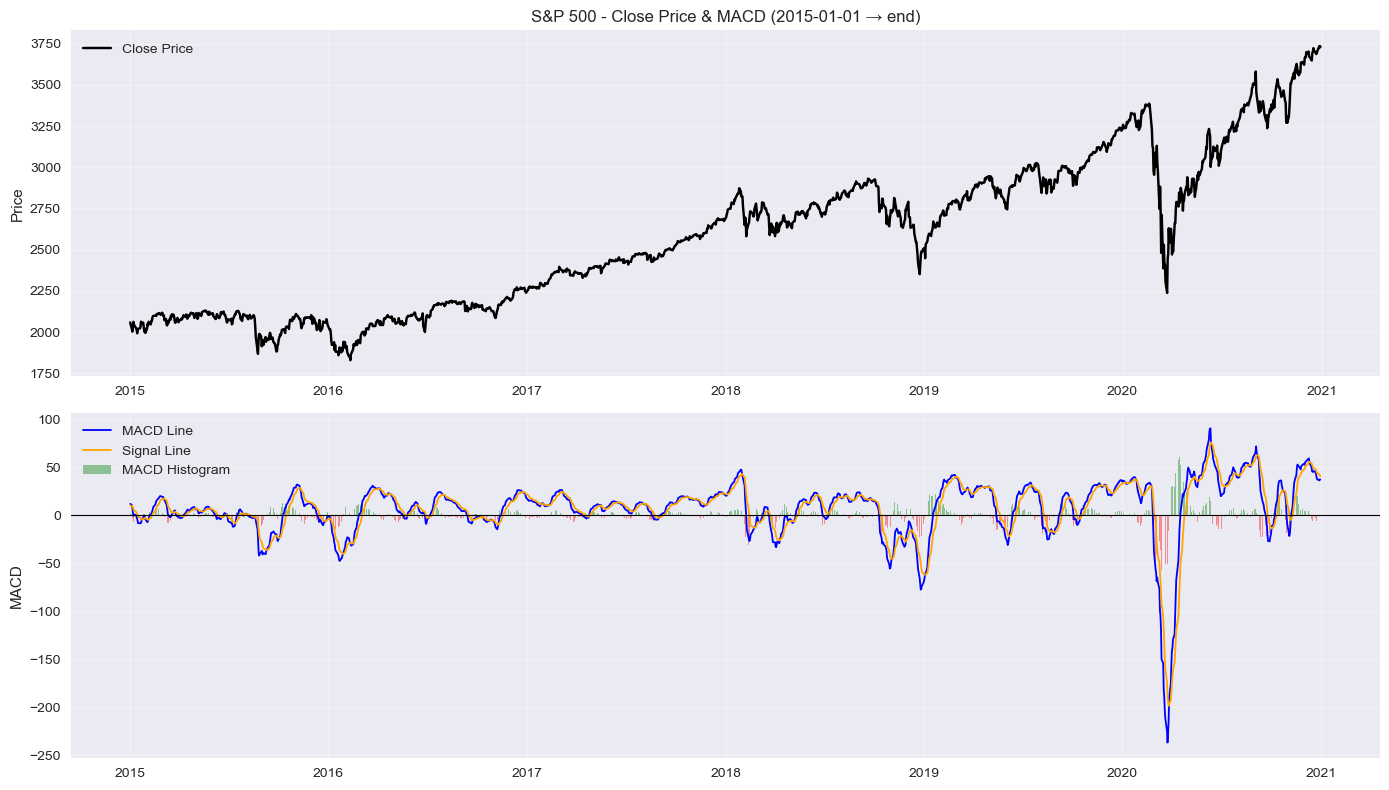

In [16]:
import matplotlib.pyplot as plt

start_plot = "2015-01-01"
end_plot = "2020-12-31"
data_plot = data.loc[start_plot:end_plot]

plt.figure(figsize=(14, 8))

# --- 1) Plot du prix ---
plt.subplot(2, 1, 1)
plt.plot(data_plot.index, data_plot["Close"], label="Close Price", color="black")
plt.title(f"S&P 500 - Close Price & MACD ({start_plot} → end)")
plt.ylabel("Price")
plt.grid(alpha=0.3)
plt.legend()

# --- 2) Plot du MACD ---
plt.subplot(2, 1, 2)
plt.plot(data_plot.index, data_plot["MACD_line"], label="MACD Line", color="blue", linewidth=1.3)
plt.plot(data_plot.index, data_plot["MACD_signal"], label="Signal Line", color="orange", linewidth=1.3)

# Histogram
plt.bar(
    data_plot.index,
    data_plot["MACD_hist"],
    label="MACD Histogram",
    color=["green" if v >= 0 else "red" for v in data_plot["MACD_hist"]],
    alpha=0.4
)

plt.axhline(0, color="black", linewidth=0.8)
plt.ylabel("MACD")
plt.grid(alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()


## RSI

The Relative Strength Index (RSI) is a momentum oscillator developed by J. Welles Wilder that measures the speed and magnitude of recent price movements to identify overbought or oversold market conditions. It oscillates between 0 and 100, typically using a 14-period window. When RSI rises above 70, it suggests that the asset may be overbought and could experience a pullback; when it falls below 30, it indicates that the asset may be oversold and due for a rebound. In trading and machine-learning contexts, RSI serves as a non-linear feature capturing momentum reversals and exhaustion in trends—helping models detect short-term shifts in market sentiment.

In [17]:
def compute_RSI(series, window=14):
    delta = series.diff()

    # Separate positive and negative changes
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)

    # Exponential moving averages (Wilder’s smoothing)
    avg_gain = gain.ewm(alpha=1/window, min_periods=window).mean()
    avg_loss = loss.ewm(alpha=1/window, min_periods=window).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

In [18]:
data["RSI_14"] = compute_RSI(data["Close"], window=14)

In [19]:
data["RSI_14"] = data["RSI_14"].shift(1)
#to prevent look ahead bias

#clean missing values
data = data.dropna()

display(data[["Close", "RSI_14"]].head())

,Close,RSI_14
Date,,
2000-01-27,1398.560059,41.903033
2000-01-28,1360.160034,39.931188
2000-01-31,1394.459961,29.536972
2000-02-01,1409.280029,43.647391
2000-02-02,1409.119995,48.450726


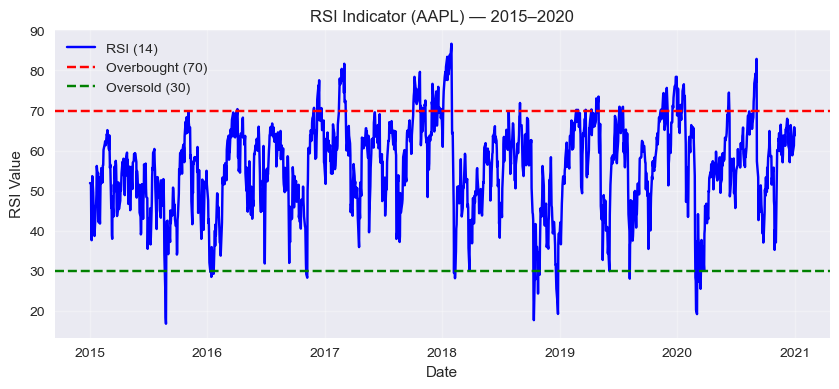

In [20]:
mask = (data.index >= "2015-01-01") & (data.index <= "2020-12-31")
subset = data.loc[mask]
plt.figure(figsize=(10, 4))
plt.plot(subset.index, subset["RSI_14"], label="RSI (14)", color="blue")
plt.axhline(70, color="red", linestyle="--", label="Overbought (70)")
plt.axhline(30, color="green", linestyle="--", label="Oversold (30)")
plt.title("RSI Indicator (AAPL) — 2015–2020")
plt.xlabel("Date")
plt.ylabel("RSI Value")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## EMA

Moving averages smooth the price and help identify trends,the EMA applies weighting factors which decrease exponentially. The weighting for each older datum decreases exponentially, never reaching zero. Momentum measures how quickly the price changes over a period (10 or 20 days).
Positive momentum means acceleration upward, negative momentum means downward acceleration.

In [21]:
#Simple Moving Averages
data["SMA_20"] = data["Close"].rolling(window=20).mean()
data["SMA_50"] = data["Close"].rolling(window=50).mean()

#Exponential Moving Average (EMA)
data["EMA_20"] = data["Close"].ewm(span=20, adjust=False).mean()

In [22]:
#difference between price and moving averages
data["Close_minus_SMA20"] = data["Close"] - data["SMA_20"]
data["Close_minus_SMA50"] = data["Close"] - data["SMA_50"]

In [23]:
#momentum indicators
data["momentum_10d"] = data["Close"].pct_change(10)
data["momentum_20d"] = data["Close"].pct_change(20)

In [24]:
#no look ahead bias
cols_to_shift = [
    "SMA_20", "SMA_50", "EMA_20",
    "Close_minus_SMA20", "Close_minus_SMA50",
    "momentum_10d", "momentum_20d"
]

data[cols_to_shift] = data[cols_to_shift].shift(1)

#clean NaN
data = data.dropna()

In [25]:
display(data[[
    "Close", "SMA_20", "SMA_50", "EMA_20",
    "Close_minus_SMA20", "momentum_10d", "momentum_20d"
]].head())

,Close,SMA_20,SMA_50,EMA_20,Close_minus_SMA20,momentum_10d,momentum_20d
Date,,,,,,,
2000-04-07,1516.349976,1473.744489,1421.819395,1475.081324,27.595477,-0.017030,0.071093
2000-04-10,1504.459961,1479.808490,1424.175193,1479.011672,36.541486,-0.007274,0.086935
2000-04-11,1500.589966,1485.850488,1427.061191,1481.435319,18.609473,-0.012731,0.087336
2000-04-12,1467.170044,1492.922485,1429.183792,1483.259571,7.667480,-0.004736,0.104065
2000-04-13,1440.510010,1496.673987,1430.341592,1481.727235,-29.503943,-0.027411,0.053895


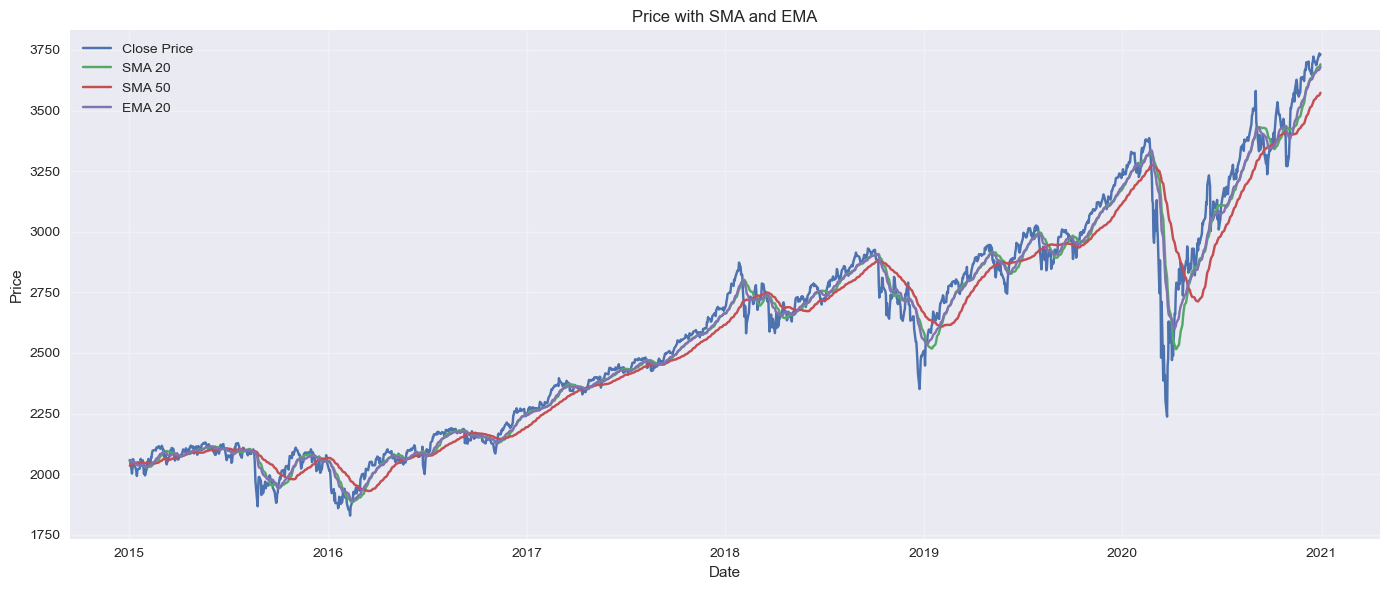

In [26]:
start_plot = "2015-01-01"
end_plot = "2020-12-31"
plot_data = data.loc[start_plot:end_plot]

plt.figure(figsize=(14, 6))

plt.plot(plot_data.index, plot_data["Close"], label="Close Price")
plt.plot(plot_data.index, plot_data["SMA_20"], label="SMA 20")
plt.plot(plot_data.index, plot_data["SMA_50"], label="SMA 50")
plt.plot(plot_data.index, plot_data["EMA_20"], label="EMA 20")

plt.title("Price with SMA and EMA")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

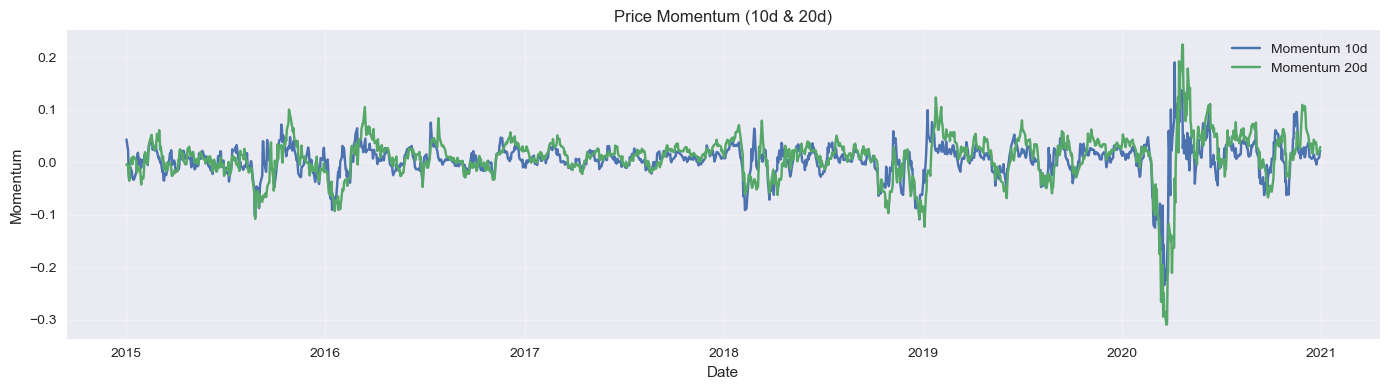

In [27]:
plt.figure(figsize=(14, 4))

plt.plot(plot_data.index, plot_data["momentum_10d"], label="Momentum 10d")
plt.plot(plot_data.index, plot_data["momentum_20d"], label="Momentum 20d")

plt.title("Price Momentum (10d & 20d)")
plt.xlabel("Date")
plt.ylabel("Momentum")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()